# Reproduce all the results in the paper

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from staNMF import staNMF
from staNMF.nmf_models import sklearn_nmf
import pickle
import networkx as nx
import scipy.ndimage as ndimage
from scipy.optimize import nnls
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [2]:
font = {'family' : 'normal',
'weight' : 'regular',
'size'   : 18}
plt.rc('font', **font)

In [3]:
#load_data
tmp = np.load('data_for_reproducibility/imputed_data_kNN_neighbor_6_weights_distance.npz')
data = tmp['imputed']
selected = tmp['selected']
original_shape = data.shape

In [4]:
#load reference atlas
areas_atlas = np.load('data_for_reproducibility/mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('data_for_reproducibility/mouse_coarse_df')

In [5]:
f = np.load("data_for_reproducibility/contours_2d.npz")
contour_x = f['contour_x']
contour_y = f['contour_y']
contour_z = f['contour_z']
contour_x = contour_x[1:, 1:]
contour_y = contour_y[1:, 1:]
contour_z = contour_z[1:, 1:]

In [6]:
# preprocess compute the support
support = np.sum(areas_atlas, 0) > 0

In [7]:
# preprocess : get the data within the reference atlas
filtered_data = data[:,:-1,:-1,:-1][:, support]
filtered_data.shape

(4345, 55954)

# staNMF instability plot

In [15]:
%cd data_for_reproducibility/

/home/ubuntu/github/allen_institute_collaboration/reproducibility/data_for_reproducibility


In [30]:
stanmf = staNMF(K1=8,
                K2=25,
                X=None,
                folderID='result',
                chunksize=2,
                parallel=True,
                processes=30,
                replicates=100,
                seed=1234)

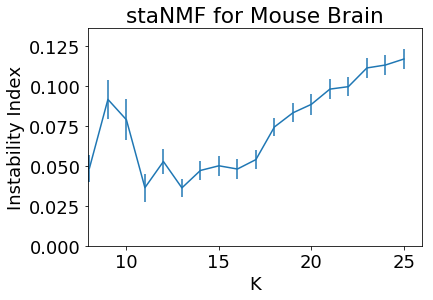

In [31]:
stanmf.plot(dataset_title="staNMF for Mouse Brain")

# Reference atlas

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


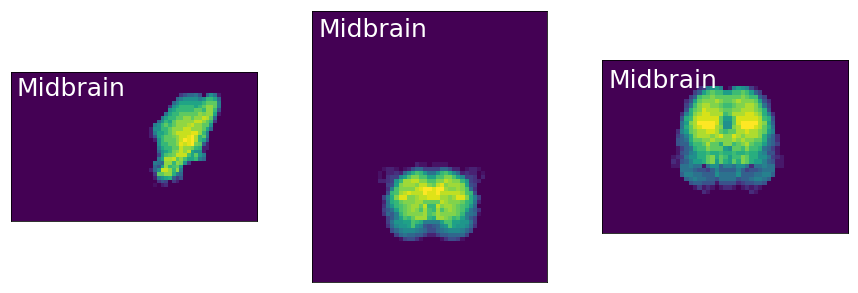

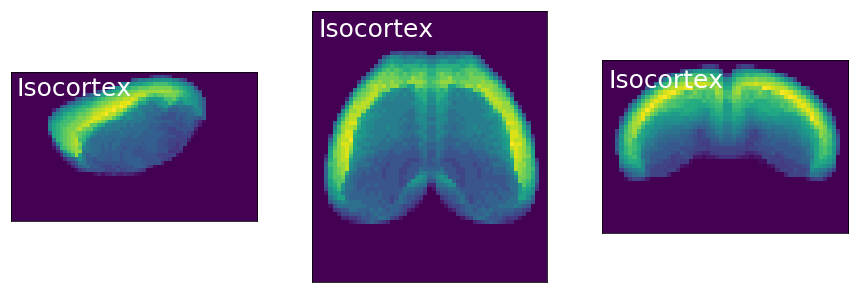

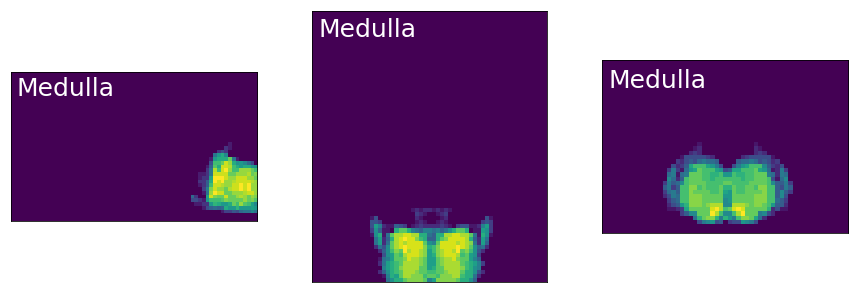

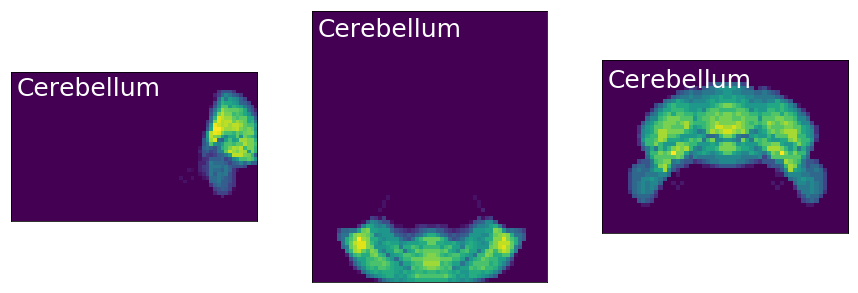

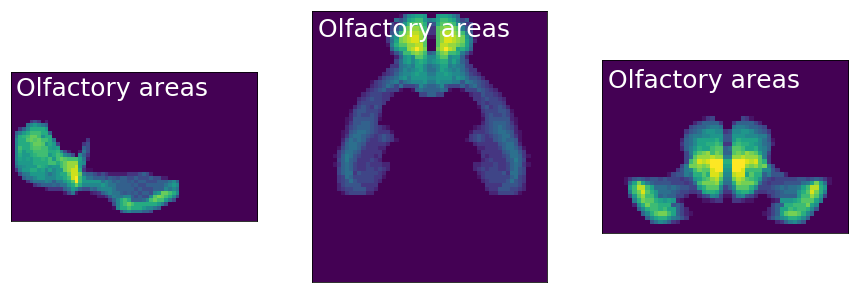

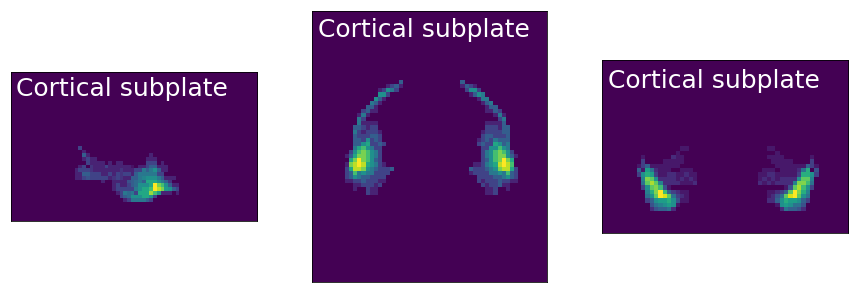

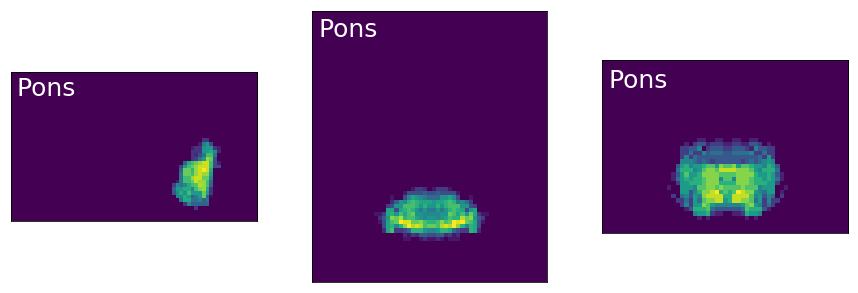

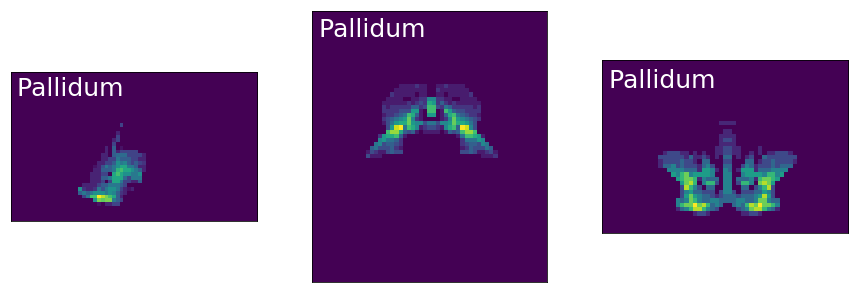

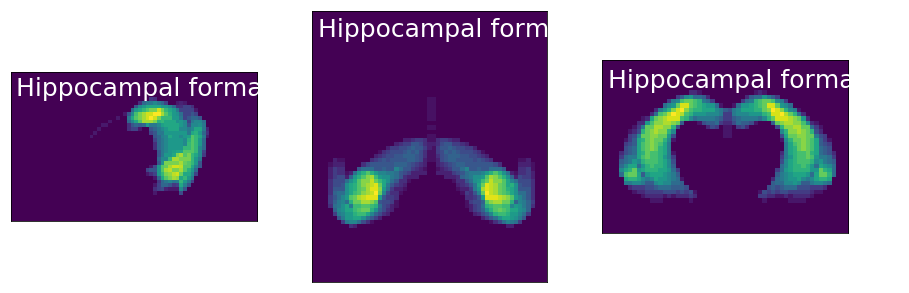

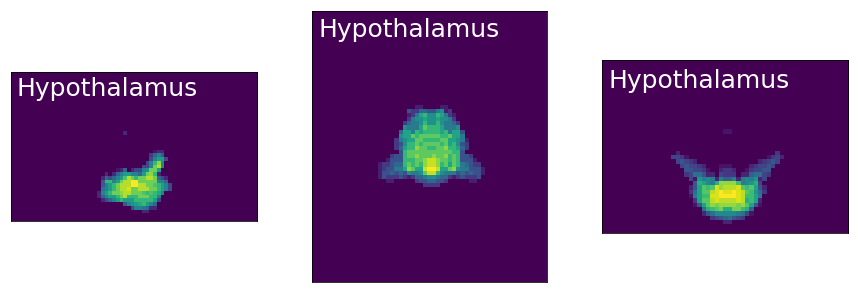

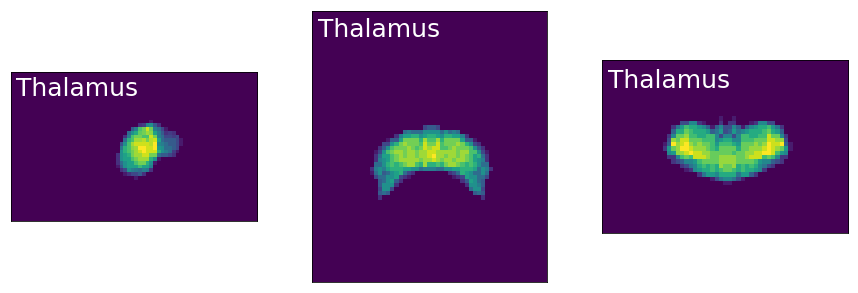

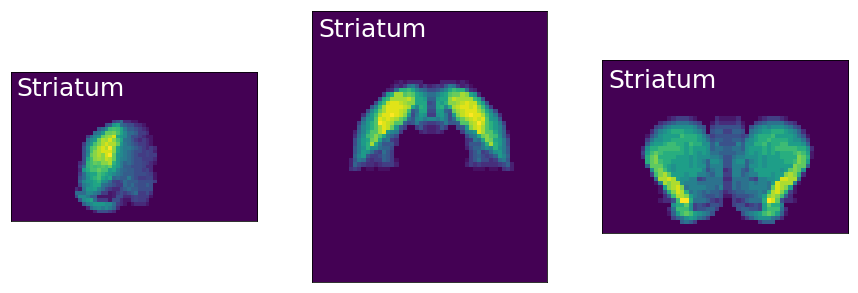

In [15]:
#visualize the PPs
for i in range(12):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    a.imshow(np.mean(areas_atlas[i, :, :, :], 2).T)
    b.imshow(np.mean(areas_atlas[i, :, :, :], 1))
    c.imshow(np.mean(areas_atlas[i, :, :, :], 0))
    a.text(1, 6, mouse_coarse_df.iloc[i]['name'], color='w', fontsize=25)
    b.text(1, 6, mouse_coarse_df.iloc[i]['name'], color='w', fontsize=25)
    c.text(1, 6, mouse_coarse_df.iloc[i]['name'], color='w', fontsize=25)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    b.axes.get_xaxis().set_visible(False)
    b.axes.get_yaxis().set_visible(False)
    c.axes.get_xaxis().set_visible(False)
    c.axes.get_yaxis().set_visible(False)

In [16]:
%cd ..

/home/ubuntu/github/allen_institute_collaboration


# Principle Patterns from NMF

In [74]:
# load
with open("./data_for_reproducibility/nmf_model_final.pickle", 'rb') as f:
    nmf = pickle.load(f)
    
nmf.components_ = reorder_PPs(nmf.components_) # reorder

for i in range(13):
    nmf.components_[i] = nmf.components_[i] / np.sqrt(np.sum(nmf.components_[i] ** 2))

In [19]:
PP_new_order = (9,6,7,0,5,2,8,4,11,12,1,3,10)
def reorder_PPs(PPs_3d):
    PPs_3d_reordered = PPs_3d.copy()
    for i in range(13):
        PPs_3d_reordered[i] = PPs_3d[PP_new_order[i]]
    return PPs_3d_reordered

In [75]:
PPs = nmf.components_
PPs_3d = np.zeros((13, 66, 40, 57))
PPs_3d[:,support] = PPs * (PPs > 0.00005)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


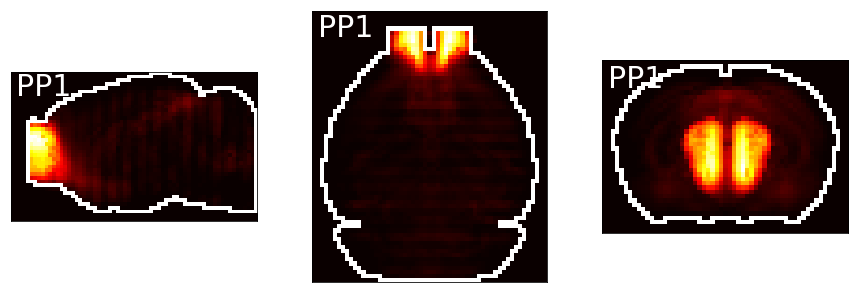

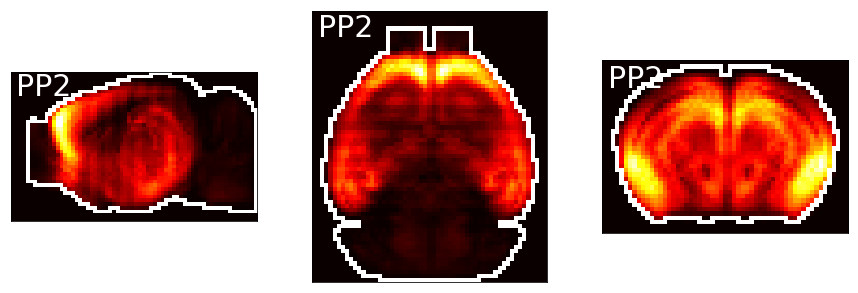

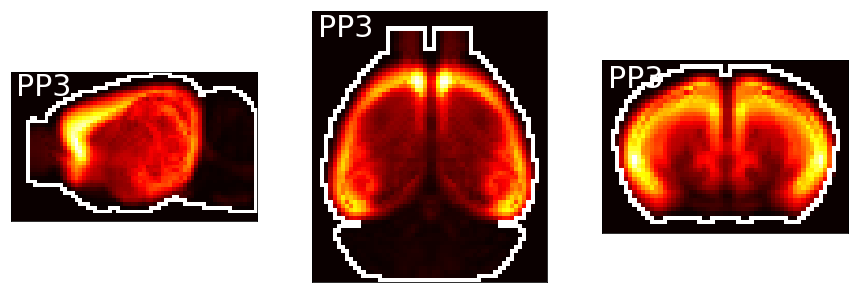

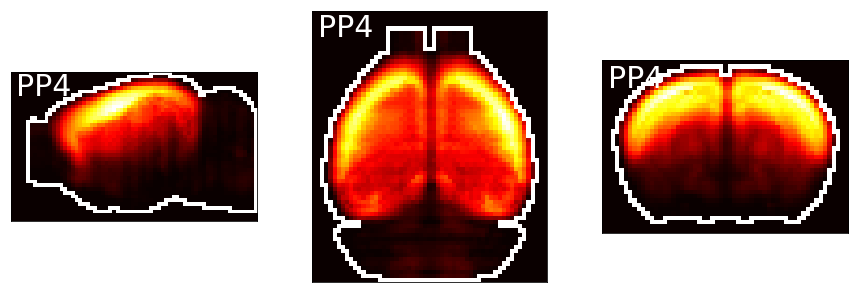

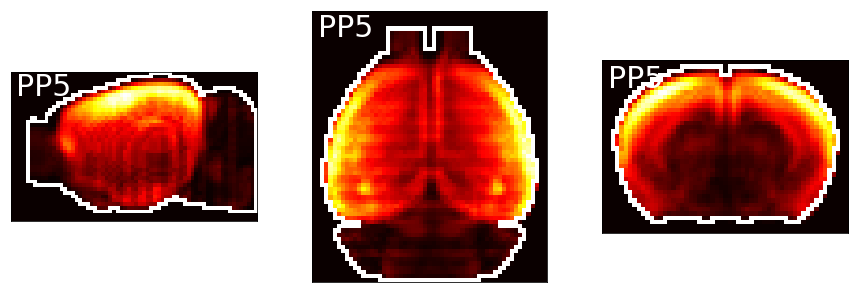

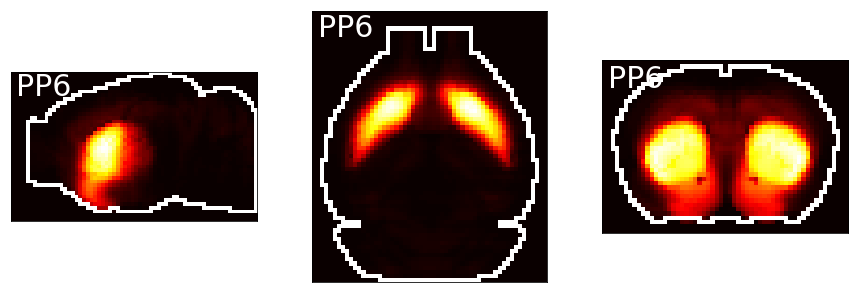

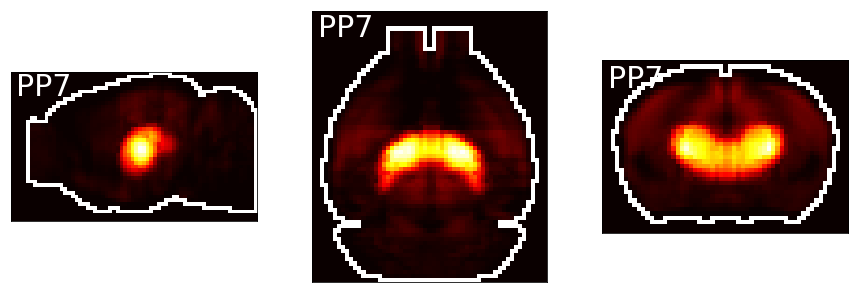

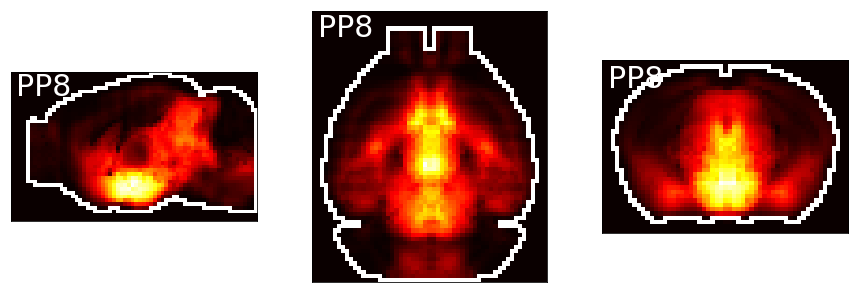

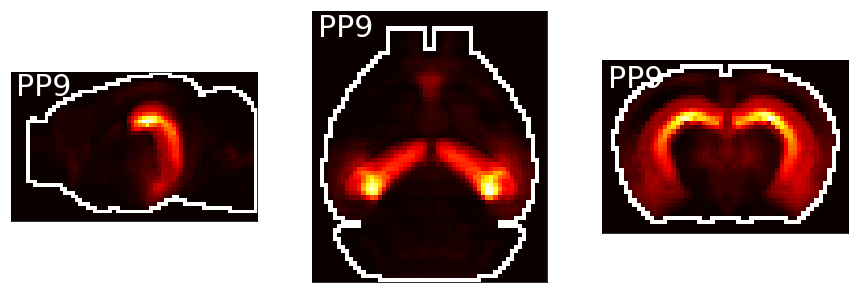

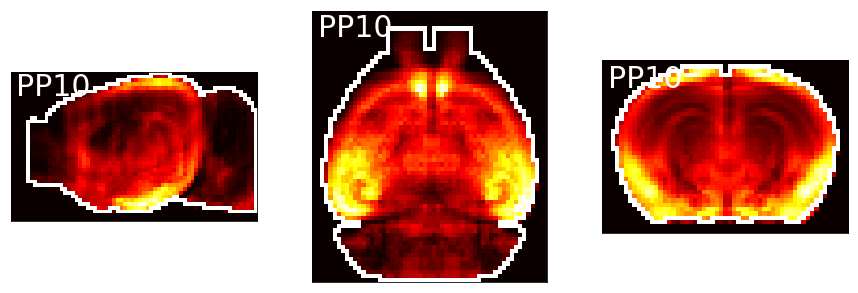

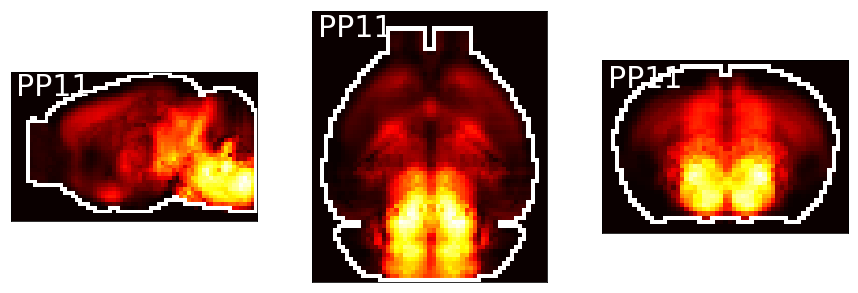

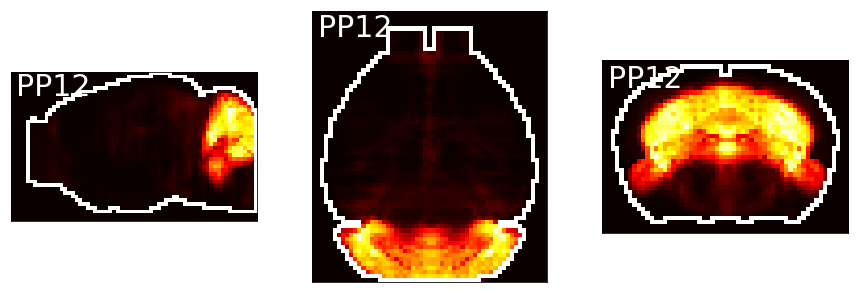

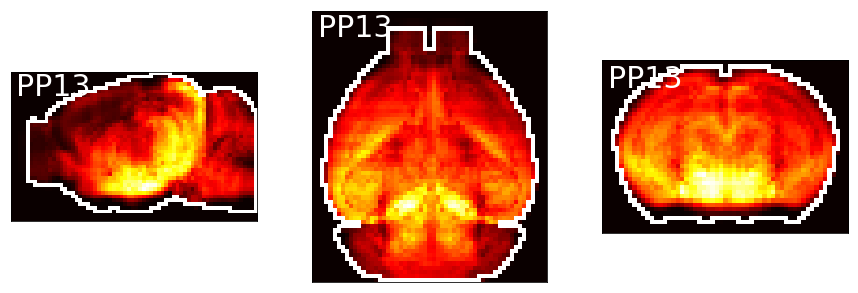

In [82]:
#visualize the PPs
for i in range(13):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    #a.imshow(contour_x*255)
    xx = np.mean(PPs_3d[i, :, :, :], 2).T
    yy = np.mean(PPs_3d[i, :, :, :], 1)
    zz = np.mean(PPs_3d[i, :, :, :], 0)       
    a.imshow(np.minimum(xx / np.max(xx) + contour_x, 1),cmap="hot")
    b.imshow(np.minimum(yy / np.max(yy) + contour_y, 1),cmap="hot")
    c.imshow(np.minimum(zz / np.max(zz) + contour_z, 1),cmap="hot")
    a.text(1, 6, 'PP{}'.format(i+1), color='w', fontsize=30)
    b.text(1, 6, 'PP{}'.format(i+1), color='w', fontsize=30)
    c.text(1, 6, 'PP{}'.format(i+1), color='w', fontsize=30)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    b.axes.get_xaxis().set_visible(False)
    b.axes.get_yaxis().set_visible(False)
    c.axes.get_xaxis().set_visible(False)
    c.axes.get_yaxis().set_visible(False)

# correlation map for NMF

In [29]:
def correlation_map_with_CCF(PPs, original_shape, plot=True, order_type = 1, area_order=None, put_last_k = 0, save_fig = False, save_index = None):
    ''' Compare PPs with the standard ABA CCF.
    '''
    # transform PPs to 4d tensor
    PPs_3d = np.zeros([PPs.shape[0]] + original_shape[1:].tolist())
    num_pps = PPs.shape[0]
    for i in range(PPs.shape[0]):
        p2 = np.reshape(PPs[i,:], original_shape[1:])
        PPs_3d[i,:,:,:] = p2
    # load ABA CCF coarse
    areas_atlas = np.load('data_for_reproducibility/mouse_coarse_structure_atlas.npy')
    mouse_coarse_df = pd.read_pickle('data_for_reproducibility/mouse_coarse_df')
    if area_order != None:
        cor_mat = np.corrcoef(np.vstack([areas_atlas.reshape(12, -1)[np.array(area_order)], PPs_3d.reshape(num_pps,-1)]))[:areas_atlas.shape[0], areas_atlas.shape[0]:]
    else:
        cor_mat = np.corrcoef(np.vstack([areas_atlas.reshape(12, -1), PPs_3d.reshape(num_pps,-1)]))[:areas_atlas.shape[0], areas_atlas.shape[0]:]
    
    if order_type == 1:
        rows, cols = linear_sum_assignment(-np.abs(cor_mat))
        factor_order = list(cols) + [x for x in range(num_pps) if x not in cols]
    elif order_type == 2:
        cols = np.argmax(np.abs(cor_mat), 0)
        if put_last_k > 0:
            # put the poorly fitted patterns at the last.
            best_fits = [abs(cor_mat[y, x]) for x, y in enumerate(cols)]
            orders = np.argsort(best_fits)
            for i in range(put_last_k):
                cols[orders[i]] = max(cols) 
        factor_order = np.argsort([ 10 * x - abs(cor_mat[x, i]) for i, x in enumerate(cols.tolist())]) # first sort by x, then sort by the value
                
            
    if plot:
        fig = plt.gcf()
        plt.figure(figsize=(10,9))
        plt.imshow(np.abs(cor_mat[:,factor_order]).tolist())
        if area_order is None:
            plt.yticks(np.arange(12),(mouse_coarse_df.iloc[:]['name'].tolist()))
        else:
            plt.yticks(np.arange(12),(mouse_coarse_df.iloc[area_order]['name'].tolist()))
        plt.ylim([-0.5, 11.5])
        plt.gca().invert_yaxis()
        plt.xticks(range(num_pps), factor_order+1)
        plt.title('Correlation Coefficient')
        plt.xlabel('Principle Patterns')
        plt.colorbar()
        plt.show()
        if save_fig:
            fig.savefig('plot_{}.png'.format(save_index))
    return np.abs(cor_mat[:,factor_order])

<Figure size 432x288 with 0 Axes>

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


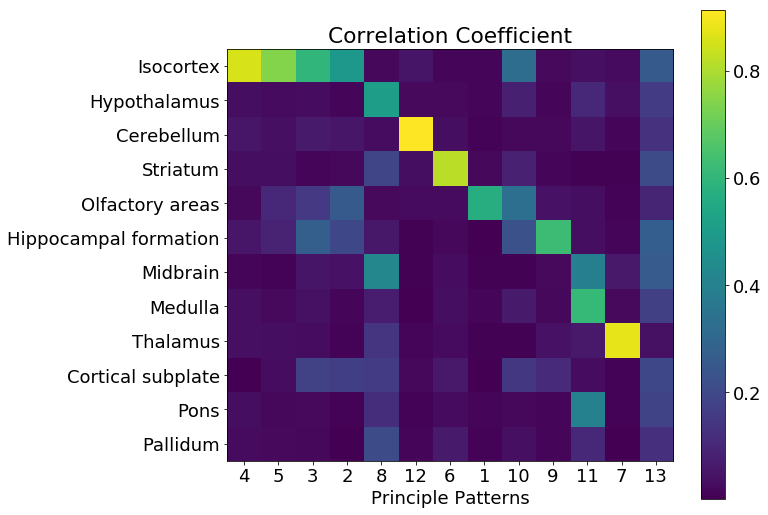

In [69]:
corr_mat = correlation_map_with_CCF(PPs_3d.reshape((PPs_3d.shape[0], 66 * 40 * 57)), np.array(PPs_3d.shape), order_type=2,area_order=[1,9,3,11,4,8,0,2,10,5,6,7], put_last_k=1)

# PCA plots

# Compare two PPs

In [31]:
#define_function a function that shows two genes together
def visualize_two_genes(geneA, geneB, colorA = 'red', colorB = 'green', missing_mask = True):    
    geneA = np.maximum(geneA, 0)
    geneB = np.maximum(geneB, 0)
    color_map = {'red':0, 'green':1, 'blue':2}
    colorA = color_map[colorA]
    colorB = color_map[colorB]
    
    if missing_mask:
        geneA = geneA > 0
        geneB = geneB > 0
        

    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    
    x_dim, y_dim, z_dim = geneA.shape
    out1 = np.zeros((y_dim, z_dim, 3))
    out1[:,:,colorA] = np.sum(geneA, 0)
    out1[:,:,colorA] /= np.max(out1[:,:,colorA])
    out1[:,:,colorB] = np.sum(geneB, 0)
    out1[:,:,colorB] /= np.max(out1[:,:,colorB])
    out1 
    c.imshow(out1)
    #plt.colorbar()
    
    out2 = np.zeros((x_dim, z_dim, 3))
    out2[:,:,colorA] = np.sum(geneA, 1)
    out2[:,:,colorA] /= np.max(out2[:,:,colorA])
    out2[:,:,colorB] = np.sum(geneB, 1)
    out2[:,:,colorB] /= np.max(out2[:,:,colorB])
    
    b.imshow(out2)
    #plt.colorbar()
    
    plt.figure()
    
    out3 = np.zeros((y_dim, x_dim, 3))
    out3[:,:,colorA] = np.sum(geneA, 2).T
    out3[:,:,colorA] /= np.max(out3[:,:,colorA])
    out3[:,:,colorB] = np.sum(geneB, 2).T
    out3[:,:,colorB] /= np.max(out3[:,:,colorB])
    
    a.imshow(out3)
    
#     a.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
#     b.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
#     c.text(1, 6, 'PP{}'.format(i), color='w', fontsize=30)
    
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    b.axes.get_xaxis().set_visible(False)
    b.axes.get_yaxis().set_visible(False)
    c.axes.get_xaxis().set_visible(False)
    c.axes.get_yaxis().set_visible(False)
    
    plt.show()

1 2


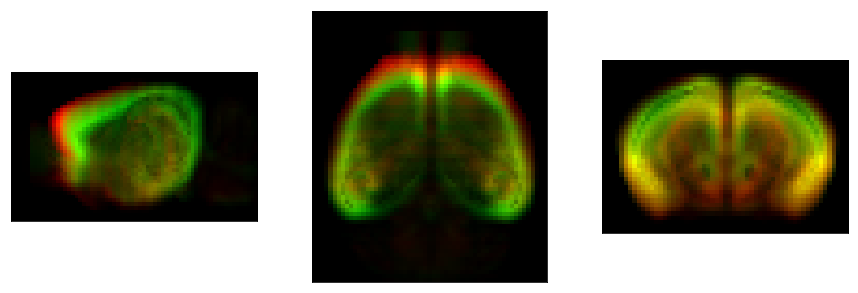

<Figure size 432x288 with 0 Axes>

1 3


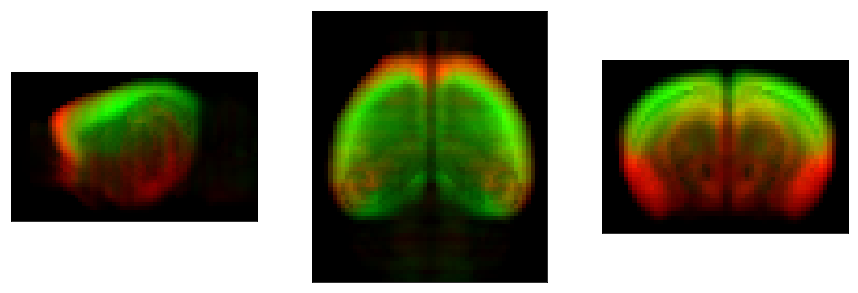

<Figure size 432x288 with 0 Axes>

1 4


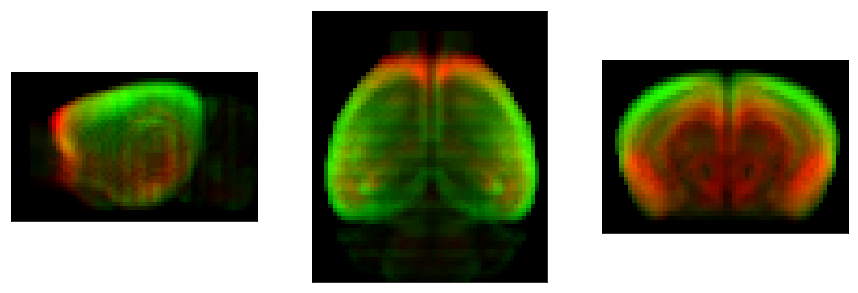

<Figure size 432x288 with 0 Axes>

2 3


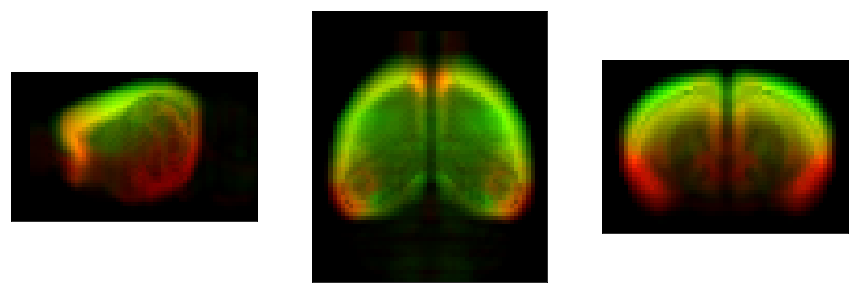

<Figure size 432x288 with 0 Axes>

2 4


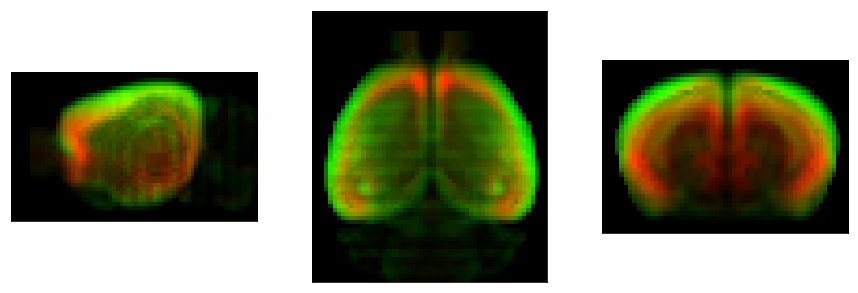

<Figure size 432x288 with 0 Axes>

3 4


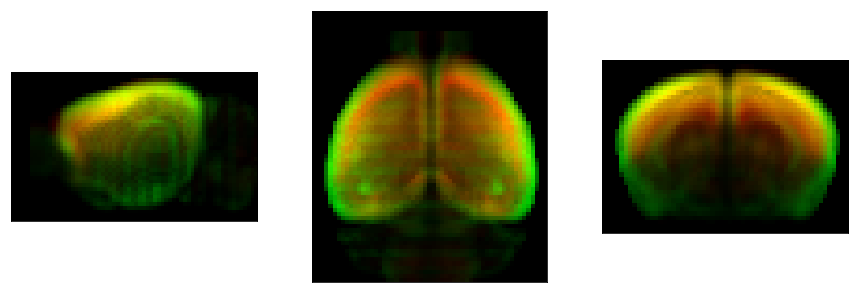

<Figure size 432x288 with 0 Axes>

In [32]:
for i in range(1,5):
    for j in range(i+1,5):
        print(i,j)
        visualize_two_genes((PPs_3d[i, :, :, :]),(PPs_3d[j, :, :, :]), missing_mask=False)

# A test for the decomposition

### linear prediction of the reference maps from PPs

In [56]:
# isocortex
ccf_ind = 1
nnls_predictor = PPs[1:5].T
nnls_coeffs = nnls(nnls_predictor, areas_atlas[ccf_ind,support].reshape(-1))
nnls_recon = np.matmul(nnls_coeffs[0], nnls_predictor.T)
print("corr coeff: ", np.corrcoef(nnls_recon, areas_atlas[ccf_ind,support].reshape(-1))[0,1])

corr_vals = []
for pp_ind in [1,2,3,4]:
    corr_vals.append(np.corrcoef(PPs[pp_ind].reshape(-1), areas_atlas[ccf_ind,support].reshape(-1))[0,1])
    print("corr coeff: ", np.corrcoef(PPs[pp_ind].reshape(-1), areas_atlas[ccf_ind,support].reshape(-1))[0,1])
    
print("corr coeff improve: ", -np.mean(corr_vals-np.corrcoef(nnls_recon, areas_atlas[ccf_ind,support].reshape(-1))[0,1]))

corr coeff:  0.8640718725336209
corr coeff:  0.3527872116510449
corr coeff:  0.49329888376056386
corr coeff:  0.8203316817477185
corr coeff:  0.6746965991534831
corr coeff improve:  0.27879327845541835


In [49]:
# isocortex - logistic regression


ccf_ind = 1
aucs = []
np.random.seed = 111
n_sub_regions = 4
for iter_ind in range(1000):
    inds_lp = np.random.choice(13,n_sub_regions, replace=False)
    predictor_mat = PPs[inds_lp].sum(axis=0)
    aucs.append(roc_auc_score(areas_atlas[ccf_ind,support].reshape(-1), predictor_mat.reshape(-1,1)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


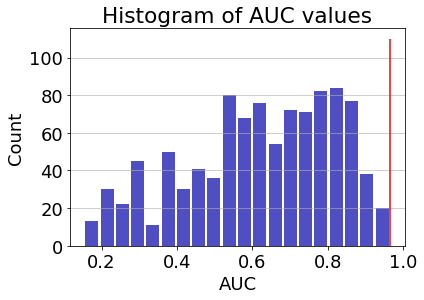

P value is 0.0


In [50]:
# isocortex - logistic regression

ccf_ind = 1
predictor_mat = np.sum(PPs[1:5],axis=0)

subregoion_auc = (roc_auc_score(areas_atlas[ccf_ind,support].reshape(-1), predictor_mat.reshape(-1,1)))
n, bins, patches = plt.hist(aucs, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.vlines(subregoion_auc,0,110, colors='r')
plt.xlabel('AUC')
plt.ylabel('Count')
plt.title('Histogram of AUC values')
plt.show()
print(f"P value is {np.mean(subregoion_auc < aucs)}")

In [60]:
# olfactory
ccf_ind = 4
nnls_predictor = PPs[[9, 0]].T
nnls_coeffs = nnls(nnls_predictor, areas_atlas[ccf_ind,support].reshape(-1))
nnls_recon = np.matmul(nnls_coeffs[0], nnls_predictor.T)
print("corr coeff: ", np.corrcoef(nnls_recon, areas_atlas[ccf_ind,support].reshape(-1))[0,1])


corr_vals = []
for pp_ind in [9,0]:
    corr_vals.append(np.corrcoef(PPs[pp_ind], areas_atlas[ccf_ind,support].reshape(-1))[0,1])
    print("corr coeff: ", np.corrcoef(PPs[pp_ind], areas_atlas[ccf_ind,support].reshape(-1))[0,1])
    
print("corr coeff improve: ", -np.mean(corr_vals-np.corrcoef(nnls_recon, areas_atlas[ccf_ind,support].reshape(-1))[0,1]))

corr coeff:  0.6131671351727249
corr coeff:  0.238542397275671
corr coeff:  0.5400989939713496
corr coeff improve:  0.2238464395492146


In [62]:
# olfactory - logistic regression

ccf_ind = 4
aucs_olf = []
np.random.seed = 1
n_sub_regions = 2
for iter_ind in range(1000):
    inds_lp = np.random.choice(13,n_sub_regions, replace=False)
    predictor_mat = np.zeros(PPs[ind_lp].shape)
    predictor_mat = PPs[inds_lp].sum(axis=0)
    aucs_olf.append(roc_auc_score(areas_atlas[ccf_ind,support].reshape(-1), predictor_mat.reshape(-1,1)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


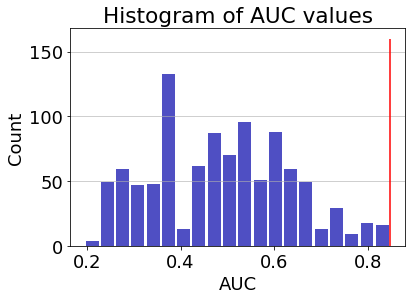

P value is 0.0


In [65]:
# olfactory - logistic regression

ccf_ind = 4
lr = LogisticRegression()
predictor_mat = np.sum(PPs[[9,0]],axis=0)

lr.fit(predictor_mat.reshape(-1,1), areas_atlas[ccf_ind,support].reshape(-1))
subregoion_auc = (roc_auc_score(areas_atlas[ccf_ind,support].reshape(-1), predictor_mat.reshape(-1,1)))

n, bins, patches = plt.hist(aucs_olf, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.vlines(subregoion_auc,0,160, colors='r')
plt.xlabel('AUC')
plt.ylabel('Count')
plt.title('Histogram of AUC values')
plt.show()
print(f"P value is {np.mean(subregoion_auc < aucs_olf)}")

In [70]:
# Hippo
ccf_ind = 8
nnls_predictor = PPs[[12,8]].T
nnls_coeffs = nnls(nnls_predictor, areas_atlas[ccf_ind,support].reshape(-1))
nnls_recon = np.matmul(nnls_coeffs[0], nnls_predictor.T)
print("corr coeff: ", np.corrcoef(nnls_recon, areas_atlas[ccf_ind,support].reshape(-1))[0,1])


corr_vals = []
for pp_ind in [12,8]:
    corr_vals.append(np.corrcoef(PPs[pp_ind].reshape(-1), areas_atlas[ccf_ind,support].reshape(-1))[0,1])
    print("corr coeff: ", np.corrcoef(PPs[pp_ind].reshape(-1), areas_atlas[ccf_ind,support].reshape(-1))[0,1])
    
print("corr coeff improve: ", -np.mean(corr_vals-np.corrcoef(nnls_recon, areas_atlas[ccf_ind,support].reshape(-1))[0,1]))

corr coeff:  0.602130354931106
corr coeff:  0.13823364409850583
corr coeff:  0.5971313946681391
corr coeff improve:  0.23444783554778353


In [68]:
# hippo - logistic regression

ccf_ind = 8
aucs_hippo = []
np.random.seed = 1
n_sub_regions = 2
for iter_ind in range(1000):
    inds_lp = np.random.choice(13,n_sub_regions, replace=False)
    predictor_mat = PPs[inds_lp].sum(axis=0)
    aucs_hippo.append(roc_auc_score(areas_atlas[ccf_ind,support].reshape(-1), predictor_mat.reshape(-1,1)))

[8 2]
[9 8]
[2 8]
[2 8]
[8 2]
[9 8]
[2 8]
[8 9]
[2 8]
[2 8]
[8 9]
[9 8]
[9 8]
[8 9]
[8 2]
[2 8]
[8 9]
[2 8]
[8 9]
[8 2]
[8 2]


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


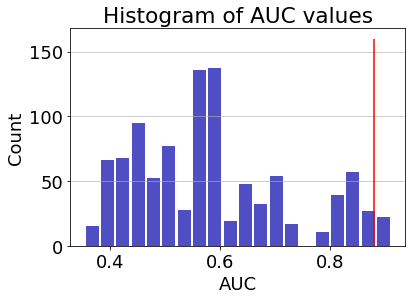

P value is 0.022


In [67]:
# olfactory - logistic regression

ccf_ind = 8
predictor_mat = PPs[[12, 8]].sum(axis=0)

lr.fit(predictor_mat.reshape(-1,1), areas_atlas[ccf_ind,support].reshape(-1))
subregoion_auc = (roc_auc_score(areas_atlas[ccf_ind,support].reshape(-1), predictor_mat.reshape(-1,1)))

# for pp_ind in [0,5,6,7]:
#     lr.fit(PPs_3d[[pp_ind], :, :, :].reshape(-1,1), areas_atlas[ccf_ind,:].reshape(-1))
#     print(roc_auc_score(areas_atlas[ccf_ind,:].reshape(-1), PPs_3d[[pp_ind], :, :, :].reshape(-1,1)))

n, bins, patches = plt.hist(aucs_hippo, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.vlines(subregoion_auc,0,160, colors='r')
plt.xlabel('AUC')
plt.ylabel('Count')
plt.title('Histogram of AUC values')
plt.show()
print(f"P value is {np.mean(subregoion_auc < aucs_hippo)}")

# PP loadings

In [71]:
tmp = np.load('data_for_reproducibility/mouse_brain_ISH_float32.npz')
data_original = tmp['data']
sections = tmp['sections'].item()
gene_ids = list(sections.keys())
original_shape = data_original.shape

In [139]:
gene_inds = []
for pp_ind in range(nmf_components.shape[0]):
    gene_per_pp = np.where(np.argmax(nmf_components,axis=0)==pp_ind)[0]
    gene_inds = np.concatenate((gene_inds, gene_per_pp))
gene_inds = gene_inds.astype(int)
D_sorted = nmf_components[:,gene_inds]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


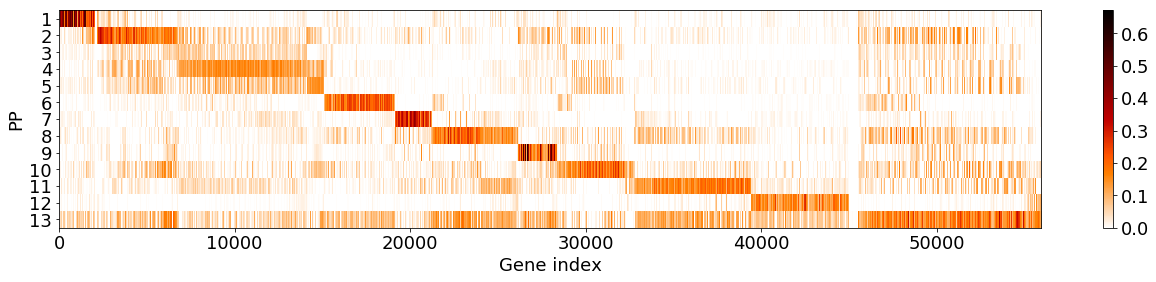

In [211]:
plt.figure(figsize=(22,4))
plt.imshow(D_sorted,interpolation='nearest', aspect='auto',cmap='gist_heat_r')
plt.yticks(range(13),np.arange(1,14))
plt.ylabel('PP')
plt.xlabel('Gene index')
plt.colorbar()

# marker genes

In [87]:
coeffs = nmf.transform(np.maximum(filtered_data,0))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


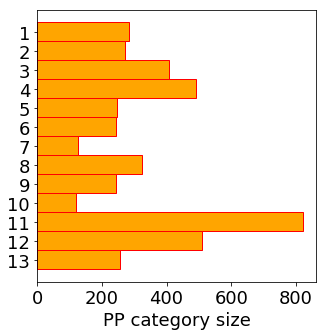

In [88]:
plt.figure(figsize=(5,5))
plt.hist(np.argmax(coeffs,axis=1),bins=np.arange(-.5,13.5,1),facecolor='orange',edgecolor='r',orientation='horizontal')
plt.yticks(range(13),np.arange(1,14))
plt.axis='off'
plt.gca().invert_yaxis()
plt.xlabel('PP category size')
plt.show()

In [91]:
# sort based on amplitude score
gene_inds = []
top_20_genes = np.zeros((coeffs.shape[1],20))
amp_metric_all = []

for pp_ind in range(coeffs.shape[1]):
    gene_per_pp = np.where(np.argmax(coeffs,axis=1)==pp_ind)[0]
    amp_metric = coeffs[gene_per_pp,pp_ind]/np.sum(coeffs[gene_per_pp],axis=1)
    amp_metric_all = np.concatenate((amp_metric_all,np.sort(amp_metric)[::-1]))
    
    gene_per_pp_arg_sort = np.argsort(amp_metric)[::-1]
    gene_inds = np.concatenate((gene_inds, gene_per_pp[gene_per_pp_arg_sort]))
    if len(gene_per_pp[gene_per_pp_arg_sort]) >= 20:
        top_20_genes[pp_ind,:] = gene_per_pp[gene_per_pp_arg_sort][:20]
    else:
        length = len(gene_per_pp[gene_per_pp_arg_sort])
        top_20_genes[pp_ind,:length] = gene_per_pp[gene_per_pp_arg_sort]
gene_inds = gene_inds.astype(int)
coeffs_sorted = coeffs[gene_inds,:]

amp_metric_all_im = np.zeros((1,amp_metric_all.shape[0]))
amp_metric_all_im[0,:] = amp_metric_all

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


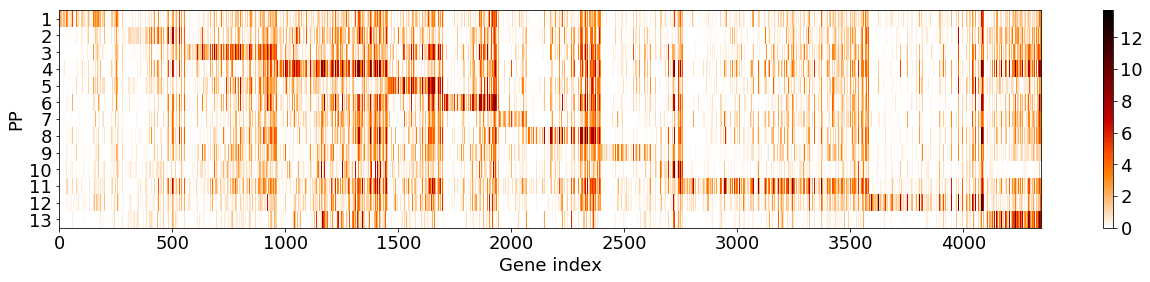

In [92]:
plt.figure(figsize=(22,4))
plt.imshow(coeffs_sorted.T,interpolation='nearest', aspect='auto',cmap='gist_heat_r')
plt.yticks(range(13),np.arange(1,14))
plt.ylabel('PP')
plt.xlabel('Gene index')
plt.colorbar()

# top genes that match to each PP

0


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


1
2
3
4
5
6
7
8
9
10
11
12


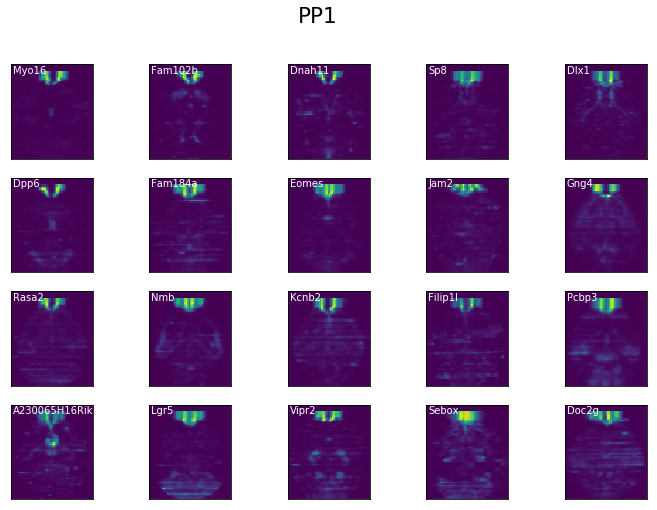

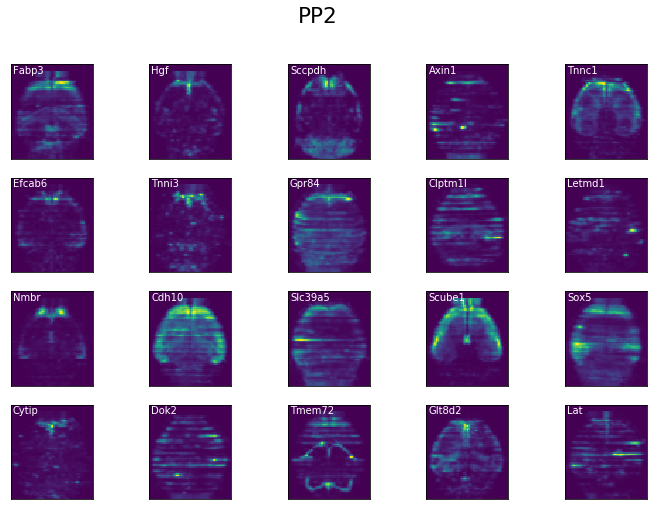

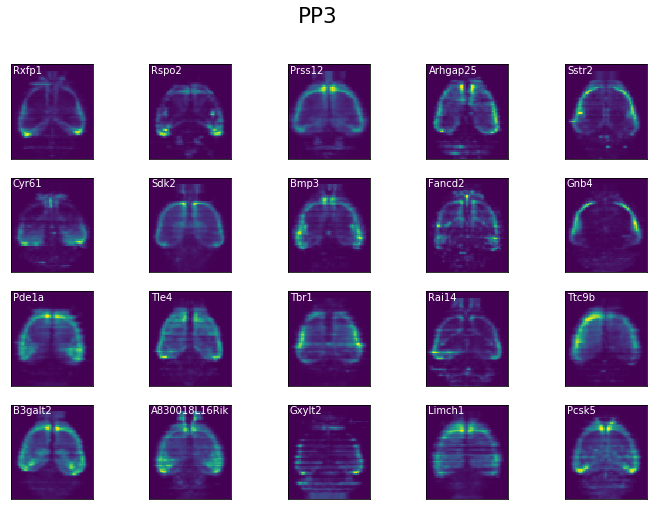

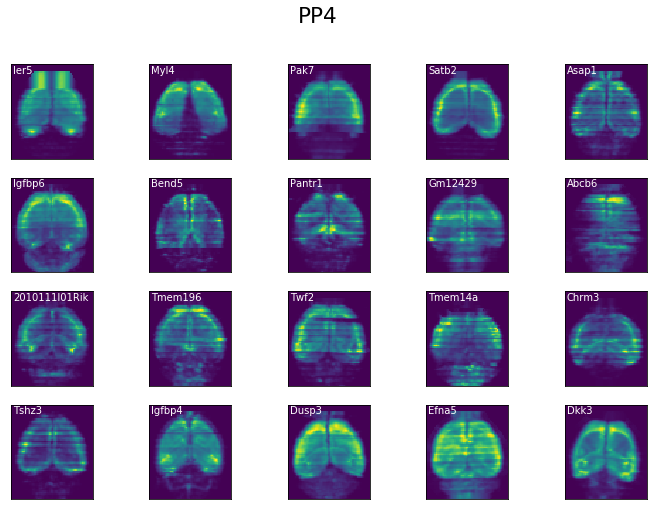

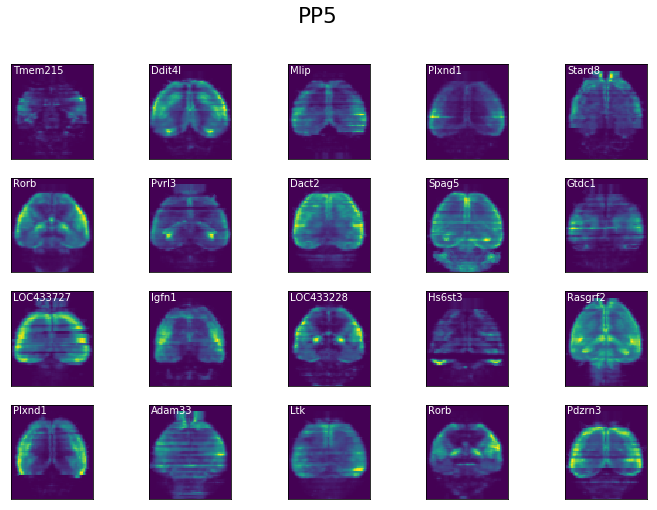

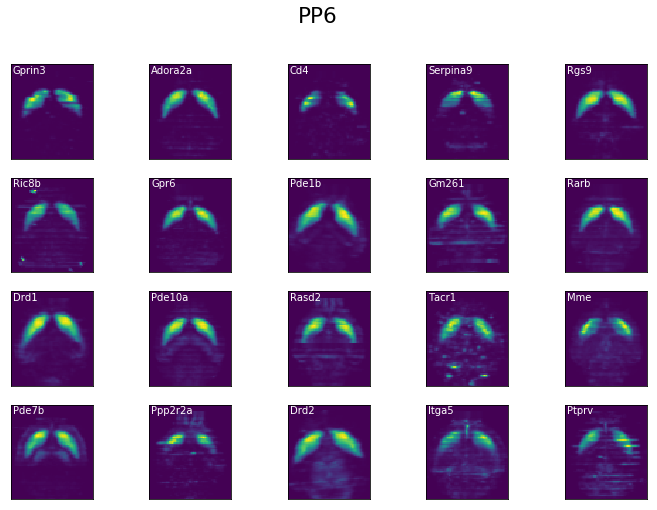

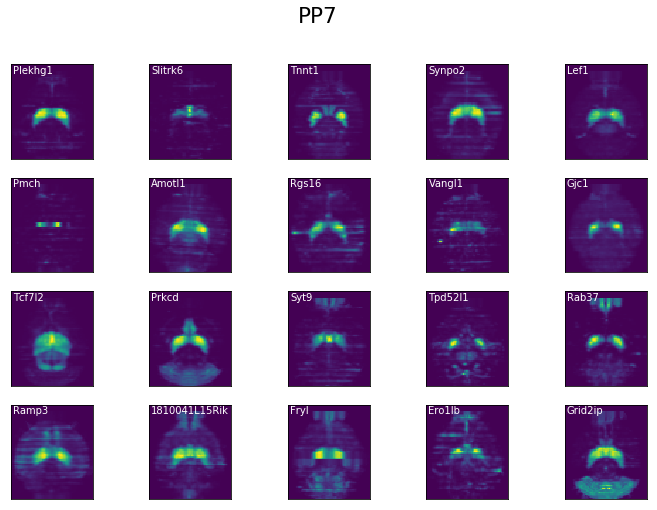

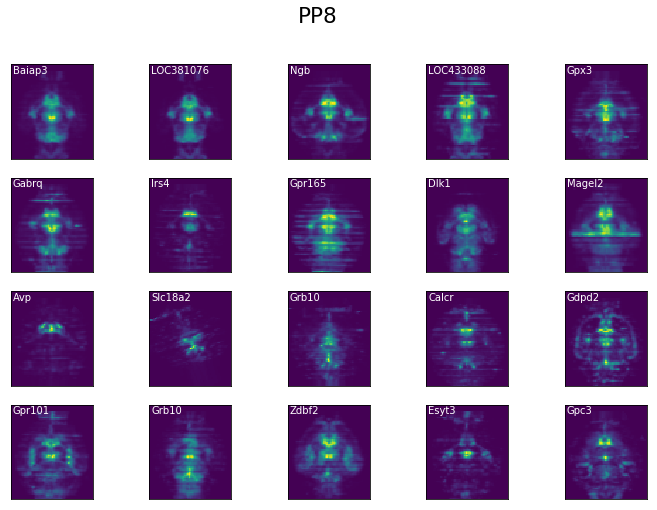

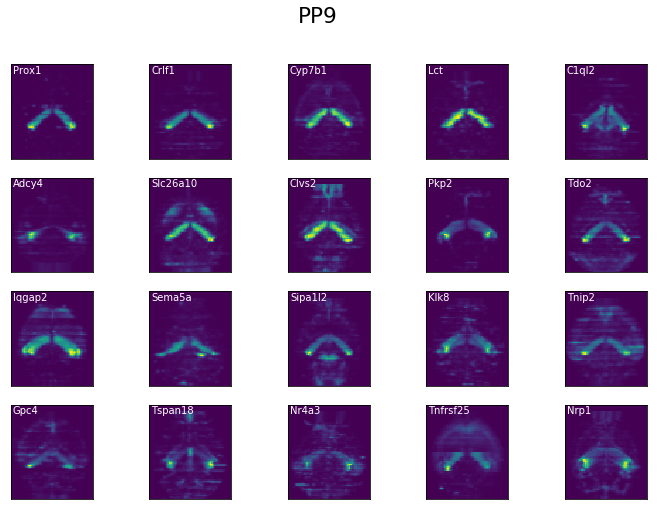

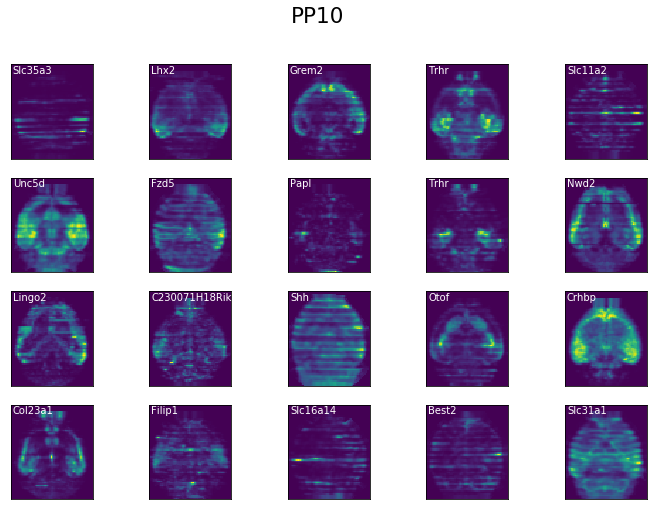

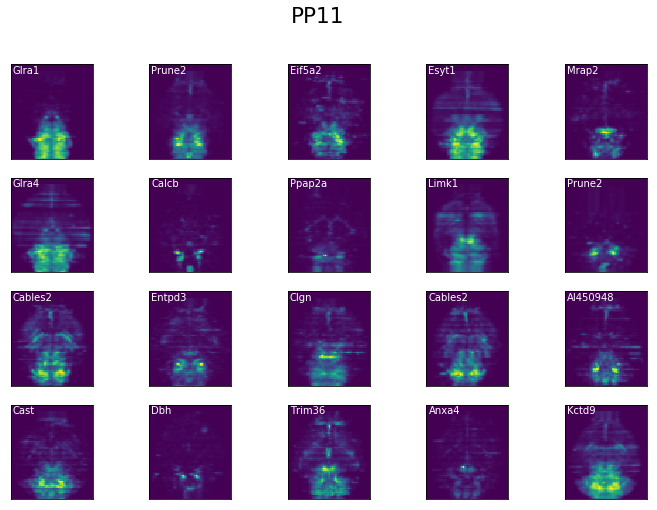

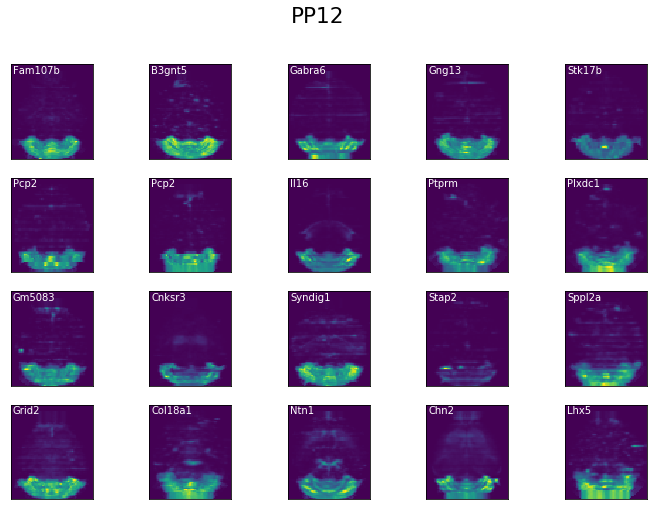

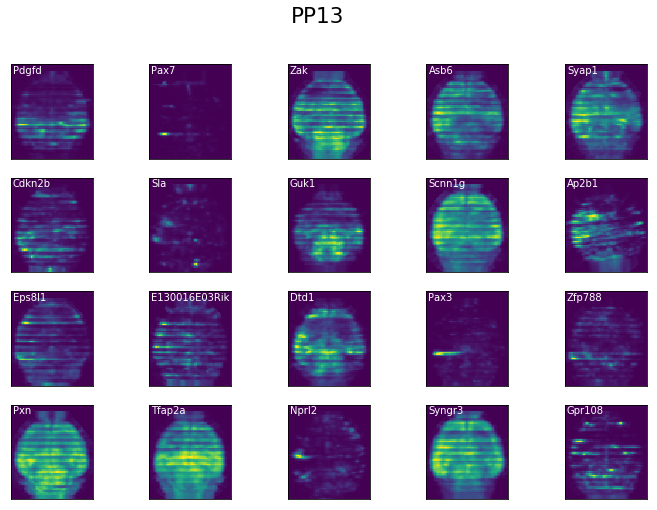

In [93]:
#visualize genes
pp_ind = 0
while pp_ind < 13:
    print(pp_ind)
    fig, axes = plt.subplots(4, 5, figsize=(12, 8))
    for gene_rank in range(20):
        gene_ind = top_20_genes[pp_ind, gene_rank].astype(int)
        #print(gene_ind)
        axes[gene_rank // 5, gene_rank % 5].axes.get_xaxis().set_visible(False)
        axes[gene_rank // 5, gene_rank % 5].axes.get_yaxis().set_visible(False)
        if gene_ind == 0:
            continue
        for x, name in sections.items():
            if x ==  gene_ids[gene_ind]:
                break
        axes[gene_rank // 5, gene_rank % 5].imshow(np.mean(np.maximum(data[gene_ind, :, :, :],0), 1))
        axes[gene_rank // 5, gene_rank % 5].text(1, 6, "{}".format(name), color='w', fontsize=10)
    fig.suptitle('PP{}'.format(pp_ind+1))
    fig.savefig('marker_gene_plots/PP_{}.png'.format(str(pp_ind+1).zfill(2)))
    pp_ind += 1